In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import  GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier


In [6]:
import sklearn
print(sklearn.__version__)

1.6.1


In [2]:
df = pd.read_csv("Debernardi et al 2020 data.csv")
df.shape

(590, 14)

In [3]:
df.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [4]:
df.columns

Index(['sample_id', 'patient_cohort', 'sample_origin', 'age', 'sex',
       'diagnosis', 'stage', 'benign_sample_diagnosis', 'plasma_CA19_9',
       'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A'],
      dtype='object')

In [5]:
columns_ = df.columns.to_list()

df = df [["stage",
          "creatinine",
           "plasma_CA19_9",
          "age",
          "sex",
          "LYVE1",
          "REG1B",
          "TFF1",
          "REG1A",
          "diagnosis"]].copy()
df.sex =df.sex.map({"M":1 , "F": 0})
df.head()

,stage,creatinine,plasma_CA19_9,age,sex,LYVE1,REG1B,TFF1,REG1A,diagnosis
0,NaN,1.83222,11.7,33,0,0.893219,52.94884,654.282174,1262.000,1
1,NaN,0.97266,NaN,81,0,2.037585,94.46703,209.488250,228.407,1
2,NaN,0.78039,7.0,51,1,0.145589,102.36600,461.141000,NaN,1
3,NaN,0.70122,8.0,61,1,0.002805,60.57900,142.950000,NaN,1
4,NaN,0.21489,9.0,62,1,0.000860,65.54000,41.088000,NaN,1


In [6]:
df.isna().sum()

stage            391
creatinine         0
plasma_CA19_9    240
age                0
sex                0
LYVE1              0
REG1B              0
TFF1               0
REG1A            284
diagnosis          0
dtype: int64

In [7]:
#encoding
df['stage'] = df['stage'].fillna('Unknown')

#  Mapping
df['stage'] = df['stage'].map({
    'I': 1,
    'IA': 1,
    'IB': 1,
    'II': 2,
    'IIA': 2,
    'IIB': 2,
    'III': 3,
    'IV': 4,
    'Unknown': 0  
})


df['stage'] = df['stage'].astype(int)
print(df['stage'].unique())

[0 1 2 3 4]


In [8]:
# missing values
#ca19-9
mean_plasma_diagnosis_1 = df.loc[df['diagnosis'] == 1, 'plasma_CA19_9'].mean()
mean_plasma_diagnosis_2 = df.loc[df['diagnosis'] == 2, 'plasma_CA19_9'].mean()
mean_plasma_diagnosis_3 =df.loc[df["diagnosis"]== 3, 'plasma_CA19_9'].mean()
df.loc[(df['diagnosis'] == 1) & (df['plasma_CA19_9'].isna()), 'plasma_CA19_9'] = mean_plasma_diagnosis_1
df.loc[(df['diagnosis'] == 2) & (df['plasma_CA19_9'].isna()), 'plasma_CA19_9'] = mean_plasma_diagnosis_2
df.loc[(df['diagnosis'] == 3) & (df['plasma_CA19_9'].isna()), 'plasma_CA19_9'] = mean_plasma_diagnosis_3
#reg1a
mean_reg1a_diagnosis_1 = df.loc[df['diagnosis'] == 1, 'REG1A'].mean()
mean_reg1a_diagnosis_2 = df.loc[df['diagnosis'] == 2, 'REG1A'].mean()
mean_reg1a_diagnosis_3 =df.loc[df["diagnosis"]== 3, 'REG1A'].mean()
df.loc[(df['diagnosis'] == 1) & (df['REG1A'].isna()), 'REG1A'] = mean_reg1a_diagnosis_1
df.loc[(df['diagnosis'] == 2) & (df['REG1A'].isna()), 'REG1A'] = mean_reg1a_diagnosis_2
df.loc[(df['diagnosis'] == 3) & (df['REG1A'].isna()), 'REG1A'] = mean_reg1a_diagnosis_3
#stage
diagnosis = df.groupby("diagnosis").mean()
diagnosis.style.highlight_max()
df.isna().sum()

stage            0
creatinine       0
plasma_CA19_9    0
age              0
sex              0
LYVE1            0
REG1B            0
TFF1             0
REG1A            0
diagnosis        0
dtype: int64

In [9]:
stage = df.groupby('stage').mean()
stage.style.highlight_max()

,creatinine,plasma_CA19_9,age,sex,LYVE1,REG1B,TFF1,REG1A,diagnosis
stage,,,,,,,,,
0,0.824389,36.963185,55.465473,0.447570,1.676618,53.481596,317.567397,397.881939,1.531969
1,0.662342,1205.392696,66.750000,0.562500,3.433940,139.968663,539.974592,1229.309656,3.000000
2,0.783678,1272.067337,67.279070,0.511628,5.397179,224.886484,1170.003243,905.071460,3.000000
3,1.074896,1635.536080,63.789474,0.644737,6.296259,221.185408,1118.929278,1146.757745,3.000000
4,1.078759,1941.427416,69.904762,0.666667,7.348032,316.456271,1632.152213,1993.701515,3.000000


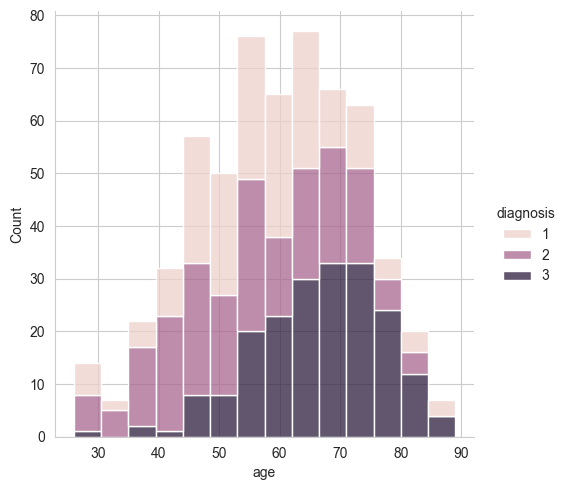

In [10]:
for feature in ['age']:
    sns.displot(df, x =feature, hue = "diagnosis", multiple = "stack", color = "gbr")

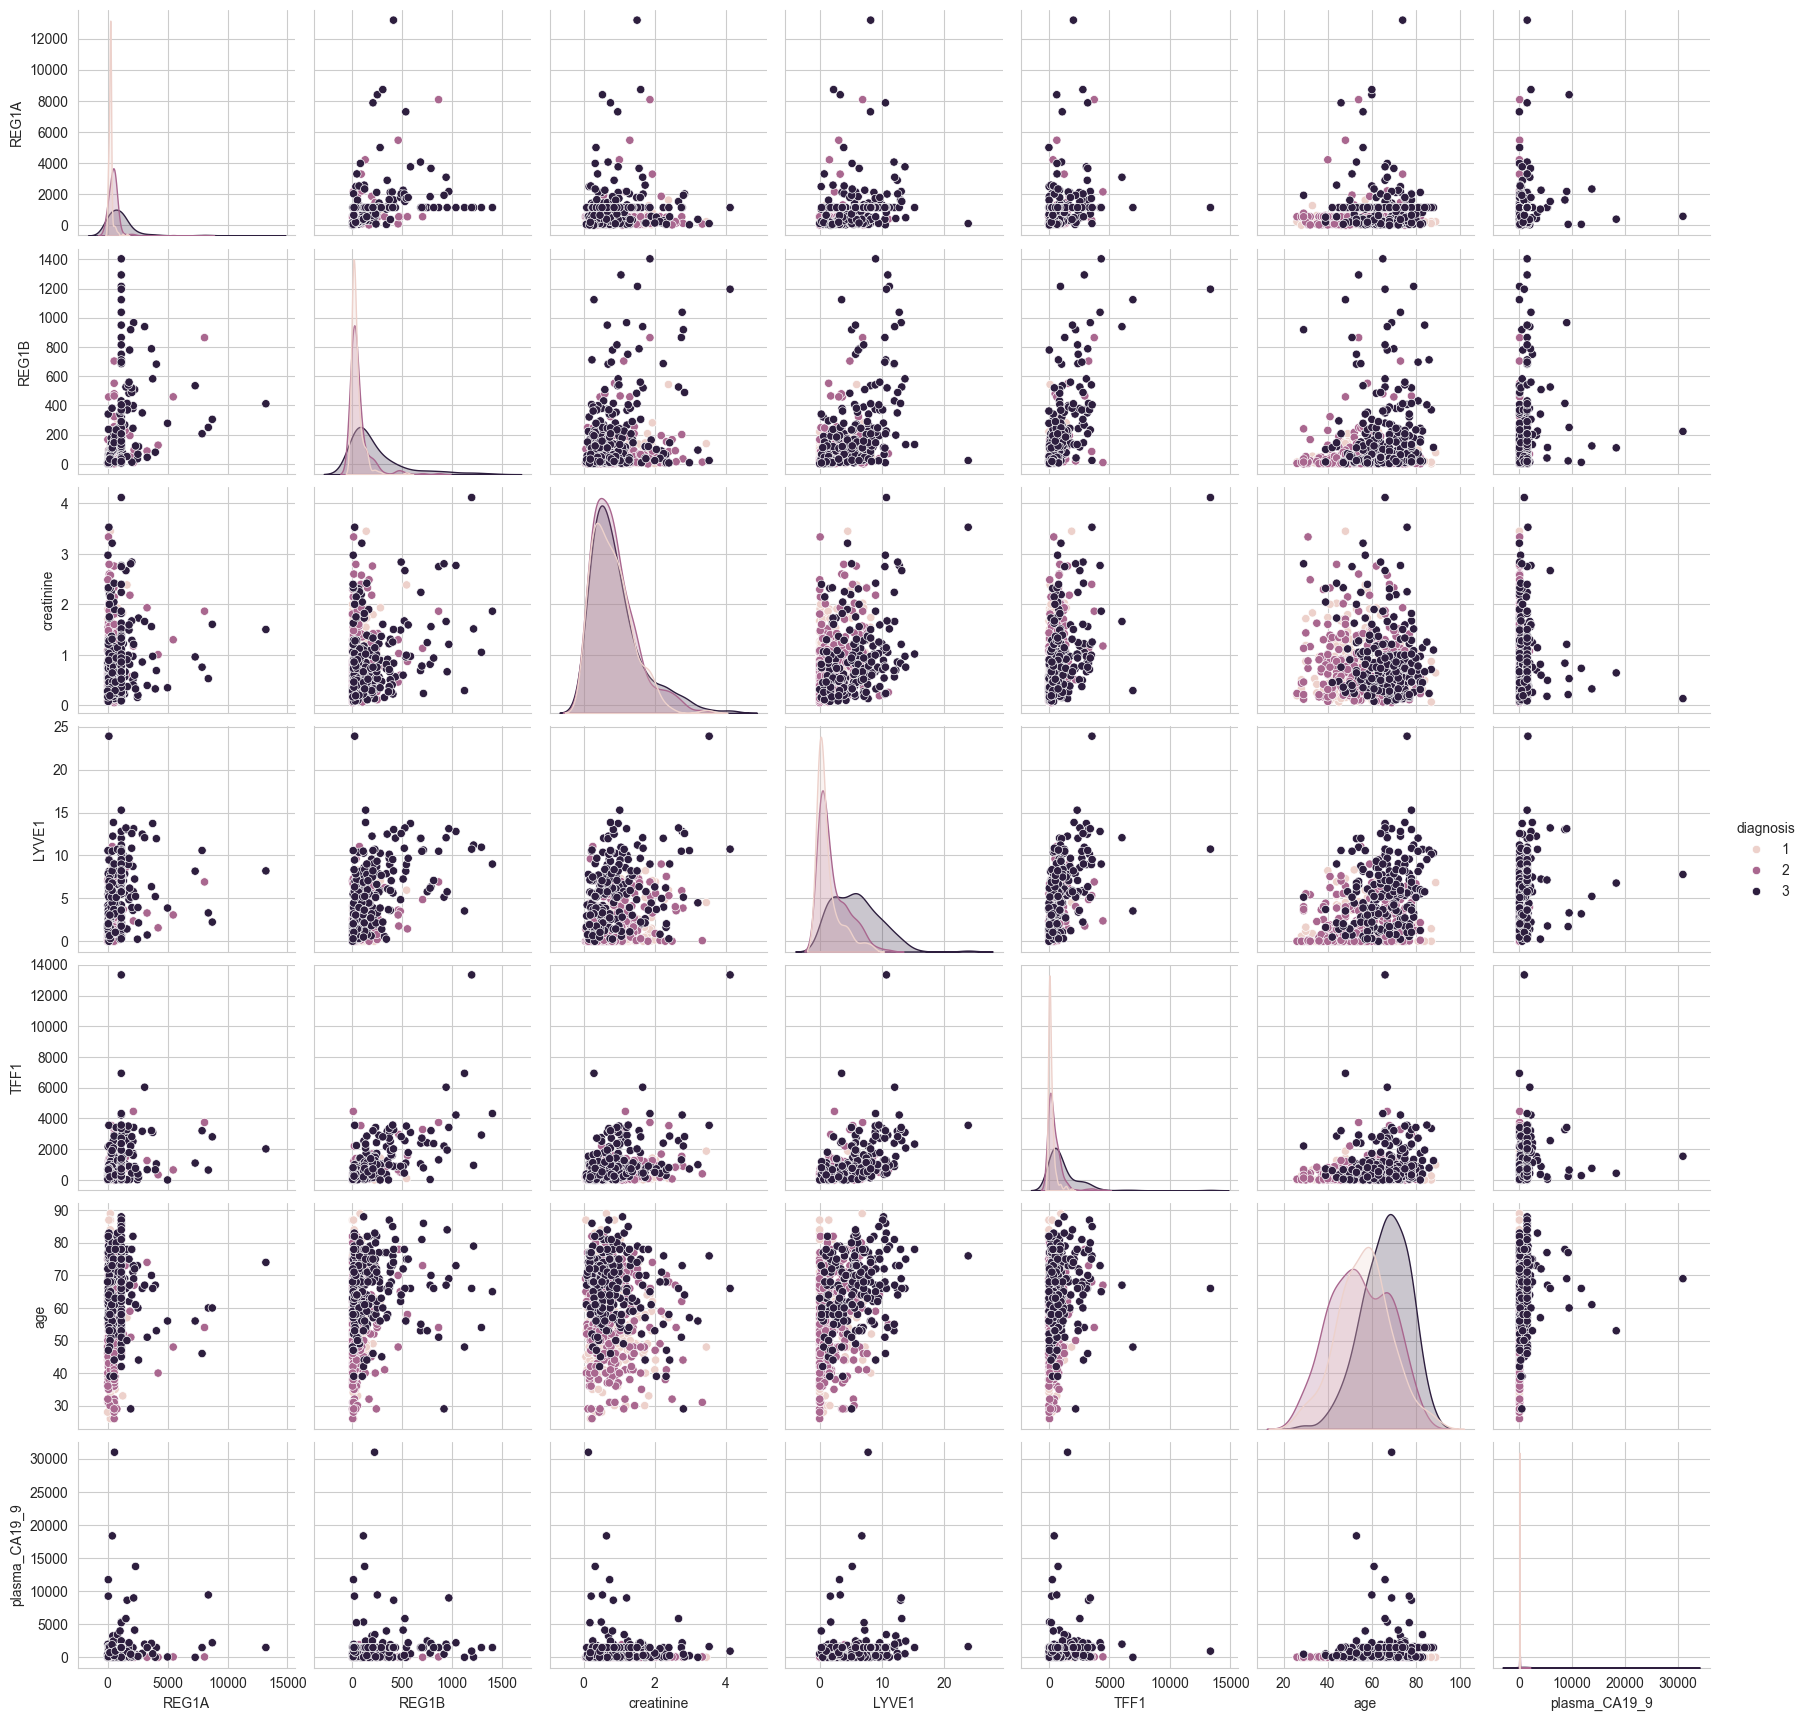

In [11]:
sns.pairplot(data = df, vars=['REG1A','REG1B', 'creatinine', 'LYVE1', 'TFF1',"age","plasma_CA19_9"], hue='diagnosis', diag_kind='kde')

<Axes: >

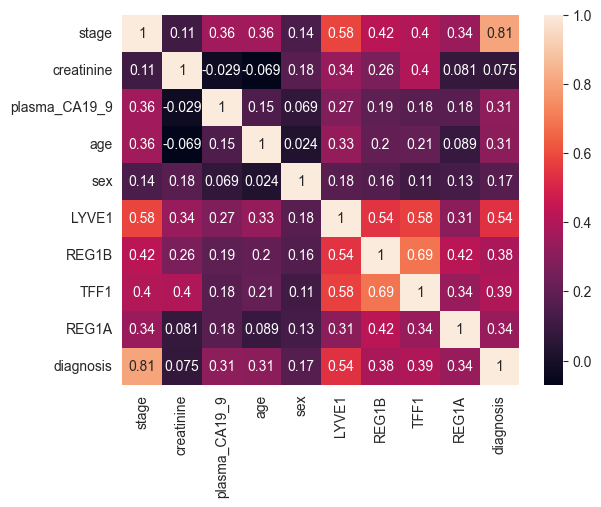

In [13]:
corr = df.dropna().corr()
sns.heatmap(corr, annot=True)

In [12]:
#  Z-scores
from scipy import stats

z_scores = stats.zscore(df.select_dtypes(include=['float64', 'int64']))
abs_z_scores = abs(z_scores)


threshold = 3

outliers = (abs_z_scores > threshold)
outlier_rows = df[(outliers).any(axis=1)]
print(outlier_rows)


df_cleaned = df[(abs_z_scores < threshold).all(axis=1)]
print(df_cleaned)
df_cleaned.isna().sum()

     stage  creatinine  plasma_CA19_9  age  sex      LYVE1        REG1B  \
144      0     3.44955       8.749569   48    0   4.512589   138.798730   
210      0     1.13100       9.000000   73    1   4.860454   704.236000   
257      0     1.17624      73.000000   67    1   2.373931     9.158758   
272      0     3.33645      61.785741   31    1   0.073313    12.445650   
289      0     2.79357      20.000000   44    1   3.870352    34.417047   
317      0     1.86615      61.785741   54    0   6.913633   864.366930   
322      0     1.30065      61.785741   48    1   3.067997   459.057900   
359      0     1.00659       7.900000   40    1   1.566210   128.280180   
399      1     0.96135       0.600000   56    1   8.167554   535.281600   
408      2     0.68991    1476.154733   53    1  11.954790   682.898790   
410      2     1.05183    1476.154733   54    1  10.956950  1293.819450   
422      2     0.29406       6.000000   48    1   3.530855  1124.108000   
427      2     0.13572   

stage            0
creatinine       0
plasma_CA19_9    0
age              0
sex              0
LYVE1            0
REG1B            0
TFF1             0
REG1A            0
diagnosis        0
dtype: int64

In [13]:
#train-test
from sklearn.model_selection import train_test_split
#X , y
X = df_cleaned.drop("diagnosis", axis =1)
y = df_cleaned["diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.dtypes)

stage              int32
creatinine       float64
plasma_CA19_9    float64
age                int64
sex                int64
LYVE1            float64
REG1B            float64
TFF1             float64
REG1A            float64
dtype: object


In [14]:
# KMeansSMOTE 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from imblearn.over_sampling import KMeansSMOTE

kmeans_smote = KMeansSMOTE(random_state=42)
X_resampled, y_resampled = kmeans_smote.fit_resample(X_train, y_train)


print("Original class distribution:", y_train.value_counts())
print("Resampled class distribution:", pd.Series(y_resampled).value_counts())
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)


rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

#  Boruta
boruta_selector = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    verbose=2,
    random_state=1
)


boruta_selector.fit(X_resampled, y_resampled)

selected_features = X_train.columns[boruta_selector.support_].to_list()
print("Selected Features:", selected_features)


rejected_features = X_train.columns[boruta_selector.support_ == False].to_list()
print("Rejected Features:", rejected_features)

#  new_X and new_y ( the selected features)
new_X = X_resampled[selected_features]
new_y = y_resampled
print(new_X.head())

Original class distribution: diagnosis
2    171
1    138
3    127
Name: count, dtype: int64
Resampled class distribution: diagnosis
3    176
1    171
2    171
Name: count, dtype: int64
Shape of X_resampled: (518, 9)
Shape of y_resampled: (518,)
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	1
Selected Features: ['stage', 'creatinine', 'plasma_CA19_9', 'age', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']
Rejected Features: ['sex']
   stage  creatinine  plasma_CA19_9  age      L

In [15]:
#new_x splitting
from sklearn.model_selection import train_test_split
#X , y
X = df_cleaned.drop("diagnosis", axis =1)
y = df_cleaned["diagnosis"]
new_X = X_resampled[selected_features]
new_y = y_resampled
X_train_, X_test_, y_train_, y_test_ = train_test_split(new_X, new_y, test_size=0.2, random_state=42)

print(X_train.dtypes)
print("Shape of new_X:", new_X.shape)
print("Shape of new_y:", new_y.shape)

stage              int32
creatinine       float64
plasma_CA19_9    float64
age                int64
sex                int64
LYVE1            float64
REG1B            float64
TFF1             float64
REG1A            float64
dtype: object
Shape of new_X: (518, 8)
Shape of new_y: (518,)


In [16]:
#1-DT
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    matthews_corrcoef,
    cohen_kappa_score,
    classification_report
)
from statsmodels.stats.contingency_tables import mcnemar

# Split data
X = df_cleaned.drop("diagnosis", axis=1)
y = df_cleaned["diagnosis"]
new_X = X_resampled[selected_features]
new_y = y_resampled
X_train_, X_test_, y_train_, y_test_ = train_test_split(new_X, new_y, test_size=0.2, random_state=42)

print("Data types in X_train_:\n", X_train_.dtypes)
print("Shape of new_X:", new_X.shape)
print("Shape of new_y:", new_y.shape)

#  parameter grid 
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(1, 11)),
    'min_samples_split': range(2, 11)
}

#  cross-validation
kf = KFold(n_splits=12, shuffle=True, random_state=42)
grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=kf,
    verbose=2,
    n_jobs=-1
)

# Fit model
grid_dt.fit(X, y)
best_dt = grid_dt.best_estimator_
best_dt.fit(X_train_, y_train_)

# Predictions
y_pred = best_dt.predict(X_test_)

#  metrics
accuracy = accuracy_score(y_test_, y_pred)
precision = precision_score(y_test_, y_pred, average='macro')
recall = recall_score(y_test_, y_pred, average='macro')
f1 = f1_score(y_test_, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_, best_dt.predict_proba(X_test_), multi_class='ovr')
conf_matrix = confusion_matrix(y_test_, y_pred)
mcc = matthews_corrcoef(y_test_, y_pred)
kappa = cohen_kappa_score(y_test_, y_pred)


import numpy as np
majority_class = y_train_.mode()[0]
y_pred_baseline = np.full_like(y_test_, fill_value=majority_class)


cont_table = confusion_matrix(y_pred_baseline, y_pred)

try:
    result = mcnemar([[np.sum((y_pred_baseline == 0) & (y_pred == 1)),
                        np.sum((y_pred_baseline == 0) & (y_pred == 0))],
                     [np.sum((y_pred_baseline == 1) & (y_pred == 0)),
                      np.sum((y_pred_baseline == 1) & (y_pred == 1))]])
    p_value = result.pvalue
except Exception as e:
    p_value = None
    print("McNemar's test could not be performed:", e)

#  a chi-squared test on the confusion matrix
from scipy.stats import chi2_contingency
chi2, p_val, dof, ex = chi2_contingency(conf_matrix)

# results
print(f"Best Parameters: {grid_dt.best_params_}")
print(f"Best Cross-Validation Score: {grid_dt.best_score_:.4f}\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen’s Kappa: {kappa:.4f}")
print(f"Chi-squared test p-value: {p_val:.4f}")
if p_value is not None:
    print(f"McNemar's test p-value: {p_value:.4f}")




Data types in X_train_:
 stage              int32
creatinine       float64
plasma_CA19_9    float64
age                int64
LYVE1            float64
REG1B            float64
TFF1             float64
REG1A            float64
dtype: object
Shape of new_X: (518, 8)
Shape of new_y: (518,)
Fitting 12 folds for each of 198 candidates, totalling 2376 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 3}
Best Cross-Validation Score: 0.9562

Accuracy: 0.9327
Precision: 0.9457
Recall: 0.9293
F1 Score: 0.9309
ROC AUC Score: 0.9475
Confusion Matrix:
[[36  0  0]
 [ 7 26  0]
 [ 0  0 35]]
Matthews Correlation Coefficient (MCC): 0.9049
Cohen’s Kappa: 0.8987
Chi-squared test p-value: 0.0000
McNemar's test p-value: 1.0000


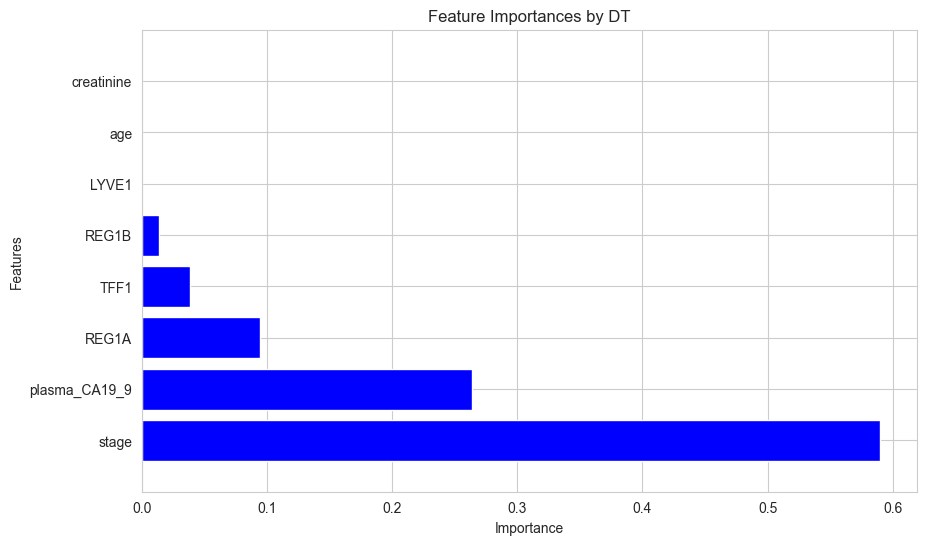

Best Decision Tree parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 9}


In [20]:
# Decision Tree parameters
importances = best_dt.feature_importances_
threshold = 0.01
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances by DT")
plt.barh(range(X_train.shape[1]), importances[indices], color="b", align="center")
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.ylim([-1, X_train.shape[1]])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()
print("Best Decision Tree parameters:", grid_dt.best_params_)

stage              int32
creatinine       float64
plasma_CA19_9    float64
age                int64
LYVE1            float64
REG1B            float64
TFF1             float64
REG1A            float64
dtype: object
Shape of new_X: (518, 8)
Fitting 12 folds for each of 96 candidates, totalling 1152 fits
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=1, weig

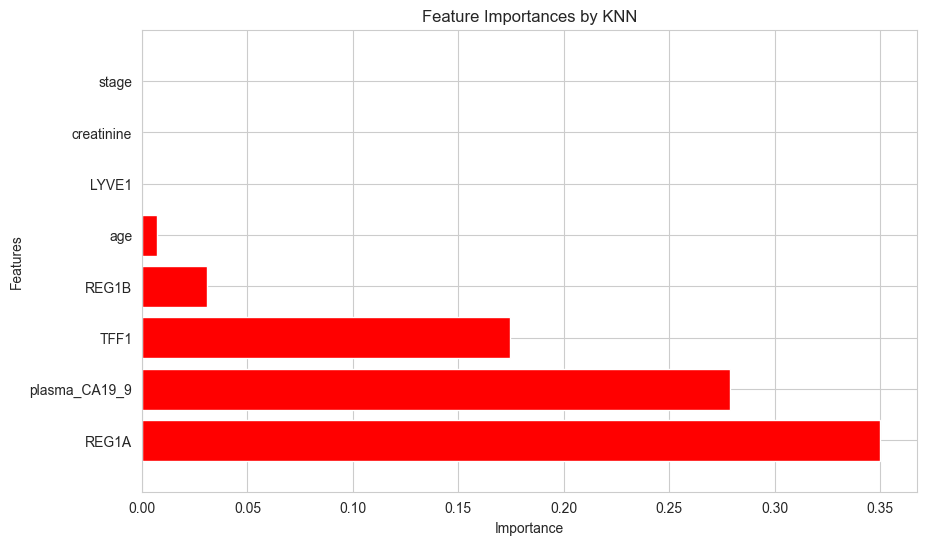

Best KNN parameters: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


In [23]:
#knn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from scipy.stats import chi2_contingency

# X, y
X = df_cleaned.drop("diagnosis", axis=1)
y = df_cleaned["diagnosis"]
new_X = X_resampled[selected_features]
new_y = y_resampled

# Split the data
X_train_, X_test_, y_train_, y_test_ = train_test_split(new_X, new_y, test_size=0.2, random_state=42)

print(X_train_.dtypes)
print("Shape of new_X:", new_X.shape)

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': np.arange(1, 25), 
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance'] 
}

#  GridSearchCV and k-fold cross-validation
k_values = range(1, 11) 
best_k = None
best_accuracy = 0
best_rf = None
kf = KFold(n_splits=12, shuffle=True, random_state=42)
grid_knn = GridSearchCV(knn, param_grid, cv=kf, scoring='accuracy', verbose=2)
grid_knn.fit(X_train_, y_train_)


print(f"Best parameters: {grid_knn.best_params_}")
print(f"Best cross-validation accuracy: {grid_knn.best_score_}")
best_knn = grid_knn.best_estimator_
y_pred = best_knn.predict(X_test_)
y_proba = best_knn.predict_proba(X_test_)
best_accuracy = 0
best_k = None  
for k in range(1, 11):  
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k



#  metrics
accuracy = accuracy_score(y_test_, y_pred)
precision = precision_score(y_test_, y_pred, average='macro')
recall = recall_score(y_test_, y_pred, average='macro')
f1 = f1_score(y_test_, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_, y_proba, multi_class='ovr')
conf_matrix = confusion_matrix(y_test_, y_pred)
mcc = matthews_corrcoef(y_test_, y_pred)
kappa = cohen_kappa_score(y_test_, y_pred)

import numpy as np
majority_class = y_train_.mode()[0]
y_pred_baseline = np.full_like(y_test_, fill_value=majority_class)


cont_table = confusion_matrix(y_pred_baseline, y_pred)

try:
    result = mcnemar([[np.sum((y_pred_baseline == 0) & (y_pred == 1)),
                        np.sum((y_pred_baseline == 0) & (y_pred == 0))],
                     [np.sum((y_pred_baseline == 1) & (y_pred == 0)),
                      np.sum((y_pred_baseline == 1) & (y_pred == 1))]])
    p_value = result.pvalue
except Exception as e:
    p_value = None
    print("McNemar's test could not be performed:", e)


from scipy.stats import chi2_contingency
chi2, p_val, dof, ex = chi2_contingency(conf_matrix)

print(f"P-value from McNemar test: {p_value:.4f}")
print(f"Chi-squared test p-value: {p_val:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")


print(f"Confusion Matrix:\n{conf_matrix}\n")
print("Classification Report:\n", classification_report(y_test_, y_pred))


result = permutation_importance(best_knn, X_train_, y_train_, n_repeats=10, random_state=42)


indices = np.argsort(result.importances_mean)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances by KNN")
plt.barh(range(X_train_.shape[1]), result.importances_mean[indices], color="r", align="center")
plt.yticks(range(X_train_.shape[1]), X_train_.columns[indices])
plt.ylim([-1, X_train_.shape[1]])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# best parameters
print("Best KNN parameters:", grid_knn.best_params_)


In [30]:
#3-svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


X = df_cleaned.drop("diagnosis", axis=1)
y = df_cleaned["diagnosis"]
new_X = X_resampled[selected_features]
new_y = y_resampled

 
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42)

print(X_train.dtypes)
print("Shape of new_X:", new_X.shape)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))  
])

#  parameter grid f
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['linear', 'rbf']
}

# K-Fold 
k_values = range(1, 11) 
best_k = None
best_accuracy = 0
best_rf = None
kf = KFold(n_splits=12, shuffle=True, random_state=42)

#  GridSearchCV
grid_svm = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                         cv=kf, verbose=2, n_jobs=-1, scoring="accuracy")


grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_
y_pred = best_svm.predict(X_test)
y_prob = best_svm.predict_proba(X_test)[:, 1]
majority_class = y_train_.mode()[0]
y_pred_baseline = np.full_like(y_test_, fill_value=majority_class)


cont_table = confusion_matrix(y_pred_baseline, y_pred)

try:
    result = mcnemar([[np.sum((y_pred_baseline == 0) & (y_pred == 1)),
                        np.sum((y_pred_baseline == 0) & (y_pred == 0))],
                     [np.sum((y_pred_baseline == 1) & (y_pred == 0)),
                      np.sum((y_pred_baseline == 1) & (y_pred == 1))]])
    p_value = result.pvalue
except Exception as e:
    p_value = None
    print("McNemar's test could not be performed:", e)

#  a chi-squared 
from scipy.stats import chi2_contingency
chi2, p_val, dof, ex = chi2_contingency(conf_matrix)

print(f"P-value from McNemar test: {p_value:.7f}")
print(f"Chi-squared test p-value: {p_val:.7f}")
# metrics
accuracy = accuracy_score(y_test_, y_pred)
precision = precision_score(y_test_, y_pred, average='macro')
recall = recall_score(y_test_, y_pred, average='macro')
f1 = f1_score(y_test_, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_, y_proba, multi_class='ovr')
conf_matrix = confusion_matrix(y_test_, y_pred)
mcc = matthews_corrcoef(y_test_, y_pred)
kappa = cohen_kappa_score(y_test_, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Feature Importance
if grid_svm.best_params_['svm__kernel'] == 'linear':
    #  linear SVM
    coef = best_svm.named_steps['svm'].coef_[0]
    feature_importance = np.abs(coef)
else:
    #  non-linear kernels
    result = permutation_importance(best_svm, X_test, y_test, n_repeats=10, random_state=42)
    print(result)

   
    importances_mean = result.importances_mean
    
    indices = np.argsort(importances_mean)[::-1]
    feature_names = new_X.columns
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances by SVM")
    plt.barh(range(X_test.shape[1]), importances_mean[indices], color="purple", align="center")
    plt.yticks(range(X_test.shape[1]), feature_names[indices])
    plt.ylim([-1, X_test.shape[1]])
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()
    print("Permutation Importances:\n", result)



stage              int32
creatinine       float64
plasma_CA19_9    float64
age                int64
LYVE1            float64
REG1B            float64
TFF1             float64
REG1A            float64
dtype: object
Shape of new_X: (518, 8)
Fitting 12 folds for each of 12 candidates, totalling 144 fits
P-value from McNemar test: 1.0000000
Chi-squared test p-value: 0.0000000
Accuracy: 0.8654
Precision: 0.8938
Recall: 0.8594
F1 Score: 0.8580
ROC AUC Score: 0.9584
Matthews Correlation Coefficient (MCC): 0.8135
Cohen's Kappa: 0.7969


Fitting 12 folds for each of 100 candidates, totalling 1200 fits
Best parameters found:  {'var_smoothing': 6.579332246575682e-09}
P-value from McNemar test: 1.0000000
Chi-squared test p-value: 0.0000000
Accuracy on the test set: 83.65%
K-Folds: None
Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 9}
Best Score: 0.9562

Accuracy: 0.8365
Precision: 0.8931
Recall: 0.8283
F1 Score: 0.8207
ROC AUC Score: 0.9584
Confusion Matrix:
[[35  1  0]
 [13 20  0]
 [ 0  0 35]]

Matthews Correlation Coefficient (MCC): 0.7856
Cohen's Kappa: 0.7529


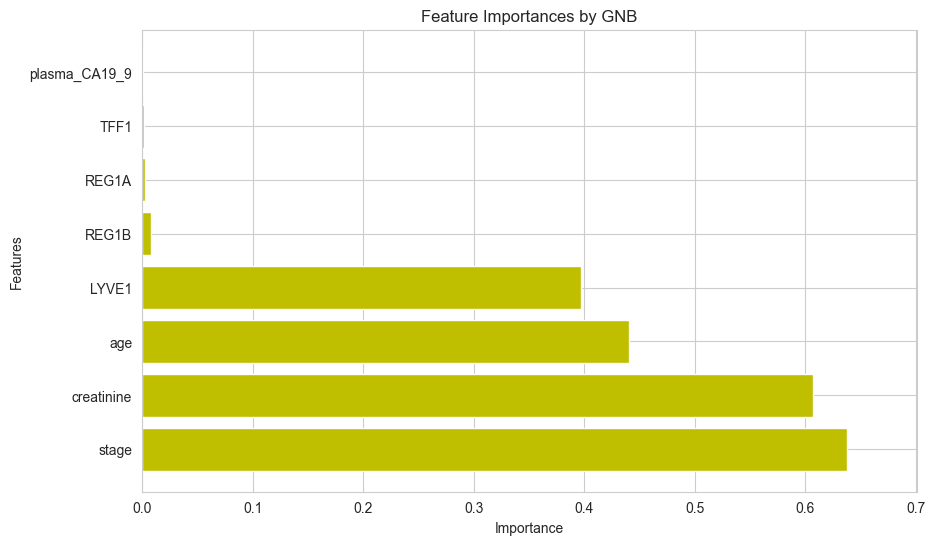

In [32]:
#4.gnb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np

X = df_cleaned.drop("diagnosis", axis=1)
y = df_cleaned["diagnosis"]
new_X = X_resampled[selected_features]
new_y = y_resampled


X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42)


gnb = GaussianNB()

param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)  # Example parameter to tune
}

# K-Fold cross-validation
k_values = range(1, 11) 
best_k = None
best_accuracy = 0
best_rf = None
kf = KFold(n_splits=12, shuffle=True, random_state=42)

# GridSearchCV
grid_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=kf, verbose=2, n_jobs=-1)
grid_gnb.fit(X_train_, y_train_)

   # Best parameters 
print("Best parameters found: ", grid_gnb.best_params_)

  # Best model
best_gnb = grid_gnb.best_estimator_

 # Predicting 
y_pred = best_gnb.predict(X_test_)
majority_class = y_train_.mode()[0]
y_pred_baseline = np.full_like(y_test_, fill_value=majority_class)


cont_table = confusion_matrix(y_pred_baseline, y_pred)

try:
    result = mcnemar([[np.sum((y_pred_baseline == 0) & (y_pred == 1)),
                        np.sum((y_pred_baseline == 0) & (y_pred == 0))],
                     [np.sum((y_pred_baseline == 1) & (y_pred == 0)),
                      np.sum((y_pred_baseline == 1) & (y_pred == 1))]])
    p_value = result.pvalue
except Exception as e:
    p_value = None
    print("McNemar's test could not be performed:", e)

#  a chi-squared 
from scipy.stats import chi2_contingency
chi2, p_val, dof, ex = chi2_contingency(conf_matrix)

print(f"P-value from McNemar test: {p_value:.7f}")
print(f"Chi-squared test p-value: {p_val:.7f}")
  
accuracy = accuracy_score(y_test_, y_pred)
print("Accuracy on the test set: {:.2f}%".format(accuracy * 100))
mcc = matthews_corrcoef(y_test_, y_pred)
kappa = cohen_kappa_score(y_test_, y_pred)
recall = recall_score(y_test_, y_pred, average='macro') 
precision = precision_score(y_test_, y_pred, average='macro')  
f1 = f1_score(y_test_, y_pred, average='macro')  
    
    # Print results
print(f"K-Folds: {best_k}")
print(f"Best Parameters: {grid_dt.best_params_}")
print(f"Best Score: {grid_dt.best_score_:.4f}\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}\n")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
means = best_gnb.theta_  
variances = best_gnb.var_  


feature_importance = np.mean(np.abs(means), axis=0) / (1 + np.mean(variances, axis=0))

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})


importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].astype(str), importance_df['Importance'], color='y')
plt.title("Feature Importances by GNB")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.xlim(0, importance_df['Importance'].max() * 1.1) 
plt.gca().invert_yaxis()  
plt.show()
  


C:\Users\Surface\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1296 fits failed out of a total of 5184.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
167 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Surface\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Surface\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\Surface\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 436, in _validate_param

Best Parameters:  {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'hinge', 'penalty': 'elasticnet'}
Best Cross-Validation Score:  0.821358543417367
P-value from McNemar test: 1.0000000
Chi-squared test p-value: 0.0000000
Accuracy on the test set: 82.69%
Matthews Correlation Coefficient (MCC): 0.7522
Cohen's Kappa: 0.7391
Best Parameters: {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'hinge', 'penalty': 'elasticnet'}
Accuracy: 0.8269
Recall: 0.8208
Precision: 0.8417
F1 Score: 0.8177
ROC AUC: 0.9584
Matthews Correlation Coefficient (MCC): 0.7522
Cohen's Kappa: 0.7391


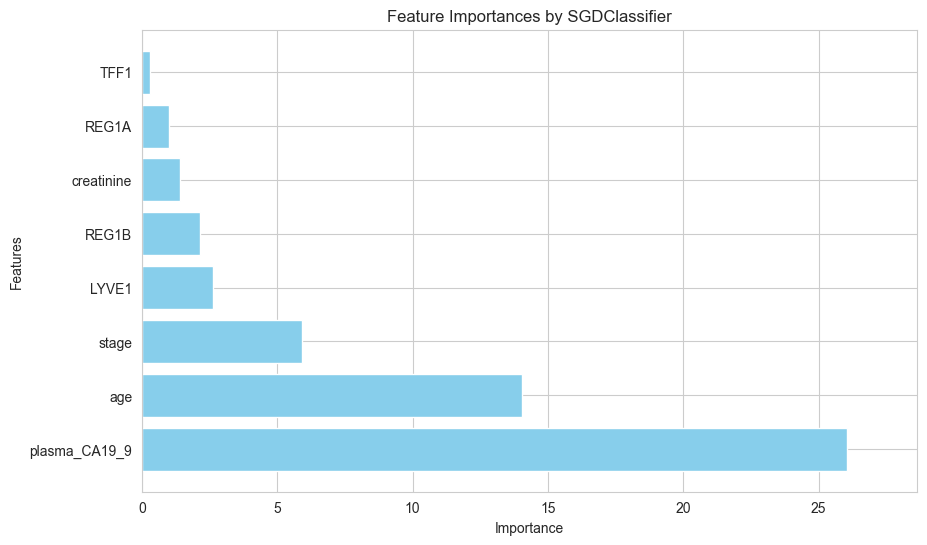

In [33]:
# 5- SGD
X = df_cleaned.drop("diagnosis", axis=1)
y = df_cleaned["diagnosis"]
new_X = X_resampled[selected_features]
new_y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42)

sgd = SGDClassifier()
for n_splits in range(3, 15):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

k_values = range(1, 11) 
best_k = None
best_accuracy = 0
best_rf = None
kf = KFold(n_splits=12, shuffle=True, random_state=42)

#  GridSearchCV PARAM
param_grid = {
    'loss': ['hinge', 'log', 'squared_hinge', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 1]
}

#  GridSearchCV 
grid_sgd = GridSearchCV(estimator=sgd, param_grid=param_grid, scoring='accuracy', cv=kf, n_jobs=-1)
grid_sgd.fit(X_train, y_train)
best_sgd = grid_sgd.best_estimator_


print("Best Parameters: ", grid_sgd.best_params_)
print("Best Cross-Validation Score: ", grid_sgd.best_score_)

#  predictions 
best_sgd = grid_sgd.best_estimator_
y_pred = best_sgd.predict(X_test)
try:
    result = mcnemar([[np.sum((y_pred_baseline == 0) & (y_pred == 1)),
                        np.sum((y_pred_baseline == 0) & (y_pred == 0))],
                     [np.sum((y_pred_baseline == 1) & (y_pred == 0)),
                      np.sum((y_pred_baseline == 1) & (y_pred == 1))]])
    p_value = result.pvalue
except Exception as e:
    p_value = None
    print("McNemar's test could not be performed:", e)

#  a chi-squared 
from scipy.stats import chi2_contingency
chi2, p_val, dof, ex = chi2_contingency(conf_matrix)

print(f"P-value from McNemar test: {p_value:.7f}")
print(f"Chi-squared test p-value: {p_val:.7f}")
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set: {:.2f}%".format(accuracy * 100))
mcc = matthews_corrcoef(y_test_, y_pred)
kappa = cohen_kappa_score(y_test_, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
recall = recall_score(y_test, y_pred, average='macro') 
precision = precision_score(y_test, y_pred, average='macro')  
f1 = f1_score(y_test, y_pred, average='macro')  

#  results
print(f"Best Parameters: {grid_sgd.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

coefficients = best_sgd.coef_  

# FEATURE importance 
feature_importance = np.mean(np.abs(coefficients), axis=0)

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})


importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].astype(str), importance_df['Importance'], color='skyblue')
plt.title("Feature Importances by SGDClassifier")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.xlim(0, importance_df['Importance'].max() * 1.1)  
plt.gca().invert_yaxis()  
plt.show()

Fitting 12 folds for each of 12 candidates, totalling 144 fits
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)
Best Cross-Validation Score: 0.973389355742297
P-value from McNemar test: 1.0000000
Chi-squared test p-value: 0.0000000
Test set accuracy:  0.9326923

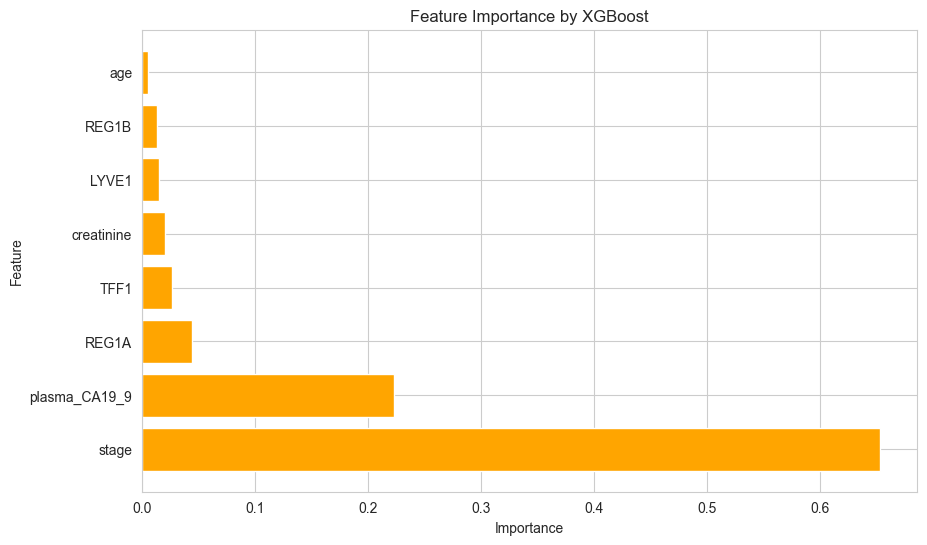

In [38]:
# 6.xgboost

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost.training")

X = df_cleaned.drop("diagnosis", axis=1)
y = df_cleaned["diagnosis"]

new_X = X_resampled[selected_features]
new_y = y_resampled

le = LabelEncoder()
new_y_encoded = le.fit_transform(new_y)


X_train, X_test, y_train, y_test = train_test_split(new_X, new_y_encoded, test_size=0.2, random_state=42)

#  model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
}

# KFold splits
kf = KFold(n_splits=12, shuffle=True, random_state=42)

#  GridSearchCV
grid_xgb = GridSearchCV(estimator=xgb_model, 
                         param_grid=param_grid, 
                         scoring='accuracy', 
                         cv=kf, 
                         verbose=1,
                         n_jobs=-1)

# Fit the model
grid_xgb.fit(X_train, y_train)

#  best score
best_xgb = grid_xgb.best_estimator_
best_score = grid_xgb.best_score_
print(f"Best Model: {best_xgb}")
print(f"Best Cross-Validation Score: {best_score}")

# predictions
y_pred = best_xgb.predict(X_test)
try:
    result = mcnemar([[np.sum((y_pred_baseline == 0) & (y_pred == 1)),
                        np.sum((y_pred_baseline == 0) & (y_pred == 0))],
                     [np.sum((y_pred_baseline == 1) & (y_pred == 0)),
                      np.sum((y_pred_baseline == 1) & (y_pred == 1))]])
    p_value = result.pvalue
except Exception as e:
    p_value = None
    print("McNemar's test could not be performed:", e)

#  a chi-squared 
from scipy.stats import chi2_contingency
chi2, p_val, dof, ex = chi2_contingency(conf_matrix)

print(f"P-value from McNemar test: {p_value:.7f}")
print(f"Chi-squared test p-value: {p_val:.7f}")
#metrics
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: ", test_accuracy)
recall = recall_score(y_test, y_pred, average='macro') 
precision = precision_score(y_test, y_pred, average='macro')  
f1 = f1_score(y_test, y_pred, average='macro')  
roc_auc = roc_auc_score(y_test, best_xgb.predict_proba(X_test), multi_class='ovr')
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Feature importance
importance = best_xgb.feature_importances_
importance_df = pd.DataFrame({
    'Feature': new_X.columns, 
    'Importance': importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)  # Sort in descending order

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="orange")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by XGBoost')
plt.gca().invert_yaxis() 
plt.show()


Best Parameters:  {'learning_rate': 1, 'n_estimators': 50}
Best Estimator:  AdaBoostClassifier(learning_rate=1)
P-value from McNemar test: 1.0000000
Chi-squared test p-value: 0.0000000
Accuracy of the best model on test data: 96.15%
Matthews Correlation Coefficient (MCC): 0.9443
Cohen's Kappa: 0.9422
Best Parameters: {'learning_rate': 1, 'n_estimators': 50}
Accuracy: 0.9615
Recall: 0.9596
Precision: 0.9667
F1 Score: 0.9610
ROC AUC: 0.9929


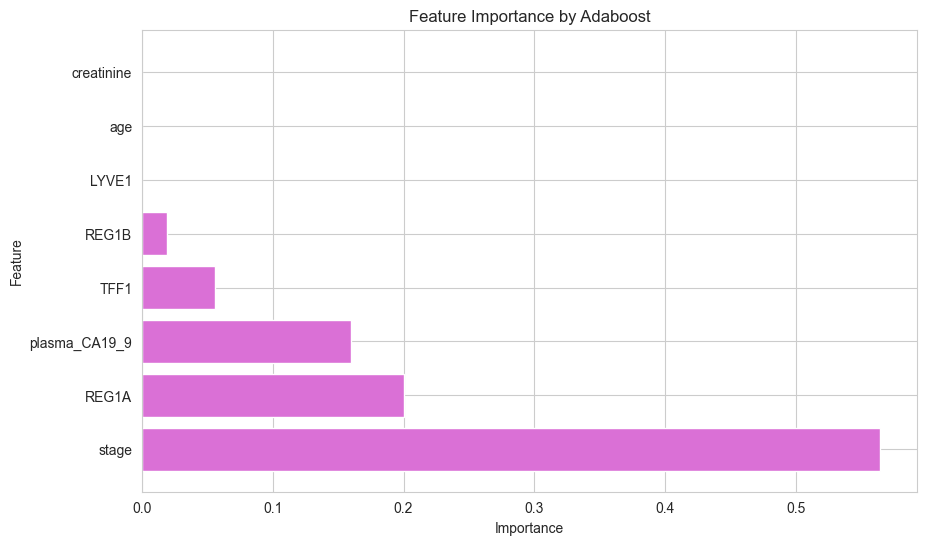

In [39]:

#7-Adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# Prepare features and labels
X = df_cleaned.drop("diagnosis", axis=1)
y = df_cleaned["diagnosis"]
new_X = X_resampled[selected_features]
new_y = y_resampled
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_X, new_y_encoded, test_size=0.2, random_state=42)


ada_boost = AdaBoostClassifier()

#  parameter grid 
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1, 10]
                                                             
}

#  K-Fold cross-validation
k_values = range(1, 11) 
best_k = None
best_accuracy = 0
best_rf = None
kf = KFold(n_splits=12, shuffle=True, random_state=42)

#  GridSearchCV
grid_ada = GridSearchCV(estimator=ada_boost,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=kf,
                           n_jobs=-1)


grid_ada.fit(X_train, y_train)


#  best params
best_params = grid_ada.best_params_
best_ada = grid_ada.best_estimator_
y_pred = best_ada.predict(X_test)

print("Best Parameters: ", best_params)
print("Best Estimator: ", best_ada)
try:
    result = mcnemar([[np.sum((y_pred_baseline == 0) & (y_pred == 1)),
                        np.sum((y_pred_baseline == 0) & (y_pred == 0))],
                     [np.sum((y_pred_baseline == 1) & (y_pred == 0)),
                      np.sum((y_pred_baseline == 1) & (y_pred == 1))]])
    p_value = result.pvalue
except Exception as e:
    p_value = None
    print("McNemar's test could not be performed:", e)

#  a chi-squared 
from scipy.stats import chi2_contingency
chi2, p_val, dof, ex = chi2_contingency(conf_matrix)

print(f"P-value from McNemar test: {p_value:.7f}")
print(f"Chi-squared test p-value: {p_val:.7f}")
accuracy = accuracy_score(y_test, y_pred)  # Use y_test instead of y
print(f"Accuracy of the best model on test data: {accuracy * 100:.2f}%")
recall = recall_score(y_test, y_pred, average='macro') 
precision = precision_score(y_test, y_pred, average='macro')  
f1 = f1_score(y_test, y_pred, average='macro')  
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Best Parameters: {grid_ada.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
# Feature importance
importance = best_ada.feature_importances_
importance_df = pd.DataFrame({
    'Feature': new_X.columns, 
    'Importance': importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)  # Sort in descending order

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="orchid")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Adaboost')
plt.gca().invert_yaxis() 
plt.show()

Best Parameters:  {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (8,), 'solver': 'adam'}
McNemar's test could not be performed: operands could not be broadcast together with shapes (104,) (103,) 
P-value from McNemar test: 0.0000000
Chi-squared test p-value: 0.0000000
              precision    recall  f1-score   support

           1       0.97      0.95      0.96        38
           2       0.94      0.91      0.93        34
           3       0.94      1.00      0.97        31

    accuracy                           0.95       103
   macro avg       0.95      0.95      0.95       103
weighted avg       0.95      0.95      0.95       103

Matthews Correlation Coefficient (MCC): 0.9274
Cohen's Kappa: 0.9270
Average Accuracy across folds:  0.9514563106796117
Accuracy: 0.9515
Recall: 0.9530
Precision: 0.9506
F1 Score: 0.9514
ROC AUC: 0.9475
         Feature  Importance
1     creatinine    0.005825
3            age    0.006796
5          REG1B    0.009709
4          LYV

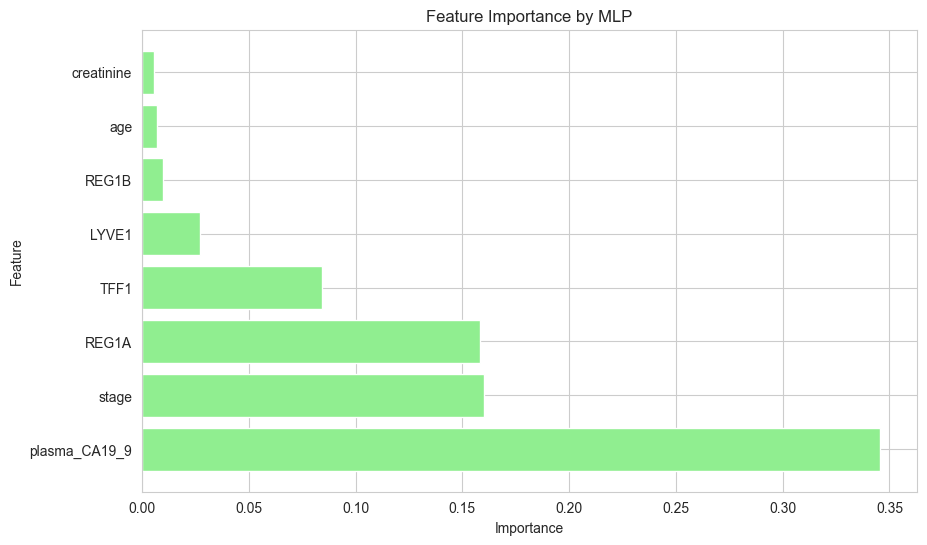

In [18]:
#8-mlp
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance

# Assuming df_cleaned, selected_features, X_resampled, and y_resampled are defined
X = df_cleaned.drop("diagnosis", axis=1)
y = df_cleaned["diagnosis"]
new_X = X_resampled[selected_features]
new_y = y_resampled
mlp = MLPClassifier(max_iter=1000)


param_grid = {
    'hidden_layer_sizes': [(i,) for i in range(3, 12)],  # Hidden layer sizes from 3 to 11
    'activation': ['relu', 'tanh', 'logistic'],  # Different activation functions
    'solver': ['adam', 'sgd'],  # Solvers
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameters
}


grid_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_mlp.fit(X_train, y_train)
best_params = grid_mlp.best_params_
print("Best Parameters: ", best_params)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for train_index, test_index in kf.split(new_X):
    X_train, X_test = new_X.iloc[train_index], new_X.iloc[test_index]
    y_train, y_test = new_y.iloc[train_index], new_y.iloc[test_index]
    

best_mlp = MLPClassifier(**best_params, max_iter=1000)
best_mlp.fit(new_X, new_y)
    

y_pred = best_mlp.predict(X_test)

try:
    result = mcnemar([[np.sum((y_pred_baseline == 0) & (y_pred == 1)),
                        np.sum((y_pred_baseline == 0) & (y_pred == 0))],
                     [np.sum((y_pred_baseline == 1) & (y_pred == 0)),
                      np.sum((y_pred_baseline == 1) & (y_pred == 1))]])
    p_value = result.pvalue
except Exception as e:
    p_value = None
    print("McNemar's test could not be performed:", e)

#  a chi-squared 
from scipy.stats import chi2_contingency
chi2, p_val, dof, ex = chi2_contingency(conf_matrix)
print(f"P-value from McNemar test: {p_val:.7f}")
print(f"Chi-squared test p-value: {p_val:.7f}")
accuracy = accuracy_score(y_test, y_pred)
fold_accuracies.append(accuracy)
print(classification_report(y_test, y_pred))

recall = recall_score(y_test, y_pred, average='macro') 
precision = precision_score(y_test, y_pred, average='macro')  
f1 = f1_score(y_test, y_pred, average='macro')  
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print("Average Accuracy across folds: ", sum(fold_accuracies) / len(fold_accuracies))
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


# Calculate permutation importance
results = permutation_importance(best_mlp, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': new_X.columns,  # Assuming X is a DataFrame
    'Importance': results.importances_mean
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)

print(importance_df)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="lightgreen")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by MLP')
plt.gca().invert_yaxis() 
plt.show()

In [ ]:
#stack ensemble
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel


X = df_cleaned.drop("diagnosis", axis=1)
y = df_cleaned["diagnosis"]
new_X = X_resampled[selected_features]
new_y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42, stratify=new_y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using a Random Forest Classifier
selector = RandomForestClassifier(n_estimators=100)
selector.fit(X_train_scaled, y_train)
model = SelectFromModel(selector, prefit=True)
X_train_selected = model.transform(X_train_scaled)
X_test_selected = model.transform(X_test_scaled)

# Define base models with hyperparameter tuning
base_models = [
    ('mlp', MLPClassifier(max_iter=2000, alpha=0.0005, hidden_layer_sizes=(150,), learning_rate='adaptive')),
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='uniform')),
    ('dt', DecisionTreeClassifier(max_depth=12, min_samples_split=4)),
    ('svm', SVC(probability=True, C=0.8, kernel='rbf', gamma='scale')),
    ('gnb', GaussianNB(var_smoothing=1e-8)),
    ('sgd', SGDClassifier(max_iter=2000, tol=1e-3, alpha=0.001)),
    ('ada', AdaBoostClassifier(n_estimators=250, learning_rate=0.5)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=500, max_depth=7, learning_rate=0.03))
]

#  hyperparameter tuning
final_estimator = RandomForestClassifier(n_estimators=300, max_depth=12, min_samples_split=10)

#  StackingClassifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=final_estimator)

# parameter grid 
param_grid = {
    'final_estimator__n_estimators': [200, 300, 400],
    'final_estimator__max_depth': [None, 10, 20, 30],
}

# GridSearchCV 
grid_stacking = GridSearchCV(estimator=stacked_model, param_grid=param_grid, cv=StratifiedKFold(n_splits=10), scoring='f1_macro', n_jobs=-1)

grid_stacking.fit(X_train_selected, y_train)

best_stacking = grid_stacking.best_estimator_
y_pred = best_stacking.predict(X_test_selected)

#  metrics
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
recall = recall_score(y_test, y_pred, average='macro') 
precision = precision_score(y_test, y_pred, average='macro')  
f1 = f1_score(y_test, y_pred, average='macro')  
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
try:
    result = mcnemar([[np.sum((y_pred_baseline == 0) & (y_pred == 1)),
                        np.sum((y_pred_baseline == 0) & (y_pred == 0))],
                     [np.sum((y_pred_baseline == 1) & (y_pred == 0)),
                      np.sum((y_pred_baseline == 1) & (y_pred == 1))]])
    p_value = result.pvalue
except Exception as e:
    p_value = None
    print("McNemar's test could not be performed:", e)

#  a chi-squared 
from scipy.stats import chi2_contingency
chi2, p_val, dof, ex = chi2_contingency(conf_matrix)
print(f"P-value from McNemar test: {p_val:.7f}")
print(f"Chi-squared test p-value: {p_val:.7f}")
#  permutation importance
results = permutation_importance(best_stacking, X_test_selected, y_test, n_repeats=10, random_state=42)

#  feature importance
importance_df = pd.DataFrame({
    'Feature': new_X.columns[model.get_support()],  # Select only the important features
    'Importance': results.importances_mean
})


importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="aqua")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Stacking-Ensemble model')
plt.gca().invert_yaxis() 
plt.show()

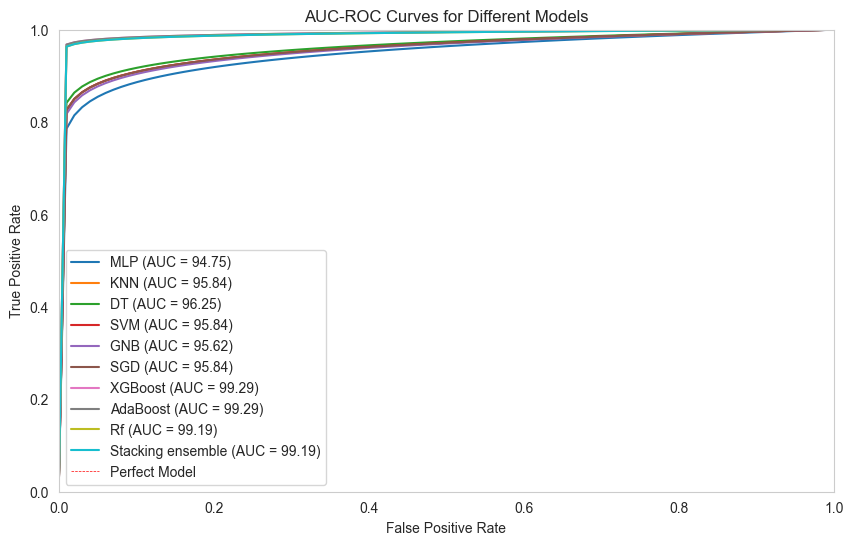

In [3]:
import matplotlib.pyplot as plt
import numpy as np
#  AUC values
models = ['MLP', 'KNN', 'DT', 'SVM', 'GNB', 'SGD', 'XGBoost', 'AdaBoost','Rf','Stacking ensemble']
auc_values = [94.75, 95.84, 96.25, 95.84, 95.62, 95.84, 99.29,99.29, 99.19, 99.19]
auc_values_normalized = [auc / 100 for auc in auc_values]
plt.figure(figsize=(10, 6))

#  AUC-ROC 
for i in range(len(models)):
    # Simulate a ROC curve
    x = np.linspace(0, 1, 100)
    y = np.clip(x ** (1 - auc_values_normalized[i]), 0, 1)  # Simulated curve based on AUC
    plt.plot(x, y, label=f"{models[i]} (AUC = {auc_values[i]:.2f})")

plt.title('AUC-ROC Curves for Different Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=1, color='r', linestyle='--', linewidth=0.5, label='Perfect Model')
plt.axvline(x=1, color='r', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid()
plt.show()

In [ ]:
#10-RF
from sklearn.metrics import precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import recall_score

X = df_cleaned.drop("diagnosis", axis=1)
y = df_cleaned["diagnosis"]
new_X = X_resampled[selected_features]
new_y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42, stratify=new_y)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

k_values = range(3, 7)  
best_k = None
best_accuracy = 0
best_rf = None

for k in k_values:
    grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=k)
    grid_rf.fit(X_train, y_train)
    best_rf = grid_rf.best_estimator_
    best_rf.fit(X_train, y_train)
    y_pred = best_rf.predict(X_test)

try:
    result = mcnemar([[np.sum((y_pred_baseline == 0) & (y_pred == 1)),
                        np.sum((y_pred_baseline == 0) & (y_pred == 0))],
                     [np.sum((y_pred_baseline == 1) & (y_pred == 0)),
                      np.sum((y_pred_baseline == 1) & (y_pred == 1))]])
    p_value = result.pvalue
except Exception as e:
    p_value = None
    print("McNemar's test could not be performed:", e)

from scipy.stats import chi2_contingency
chi2, p_val, dof, ex = chi2_contingency(conf_matrix)

print(f"P-value from McNemar test: {p_value:.7f}")
print(f"Chi-squared test p-value: {p_val:.7f}")
   #metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')
roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test), multi_class='ovr')
conf_matrix = confusion_matrix(y_test, y_pred)


if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_k = k
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best accuracy: {best_accuracy} at k = {best_k}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}\n")
#  feature importance
importance = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': new_X.columns, 
    'Importance': importance
})
importance_df = importance_df.sort_values(by='Importance', ascending=True)  # Sort in descending order
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="salmon")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Random Forest')
plt.gca().invert_yaxis() 
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


X = df_cleaned.drop("diagnosis", axis=1)
y = df_cleaned["diagnosis"]


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


selector = RandomForestClassifier(n_estimators=200)
selector.fit(X_train_scaled, y_train)
model = SelectFromModel(selector, prefit=True)
X_train_selected = model.transform(X_train_scaled)
X_test_selected = model.transform(X_test_scaled)


base_models = [
    ('mlp', MLPClassifier(max_iter=2000)),
    ('knn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('svm', SVC(probability=True)),
    ('gnb', GaussianNB()),
    ('sgd', SGDClassifier()),
    ('ada', AdaBoostClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
]


final_estimator = RandomForestClassifier()
stacked_model = StackingClassifier(estimators=base_models, final_estimator=final_estimator)

param_grid = {
    'final_estimator__n_estimators': [100, 200, 300],
    'final_estimator__max_depth': [None, 10, 20],
   
}

cv = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)
grid_stacking = GridSearchCV(estimator=stacked_model, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

grid_stacking.fit(X_train_selected, y_train)
best_stacking = grid_stacking.best_estimator_

# Predictions
y_pred = best_stacking.predict(X_test_selected)


print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro') 
precision = precision_score(y_test, y_pred, average='macro')  
f1 = f1_score(y_test, y_pred, average='macro')  
mcc = matthews_corrcoef(y_test_, y_pred)
kappa = cohen_kappa_score(y_test_, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
# Print results
print(f"Best Parameters: {grid_stacking.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


results = permutation_importance(best_stacking, X_test_selected, y_test, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X.columns[model.get_support()],  # Select only the important features
    'Importance': results.importances_mean
})


importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="aqua")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Stacking-Ensemble model')
plt.gca().invert_yaxis() 
plt.show()


In [50]:
import pandas as pd

# Verify the shape of X_test_scaled
print("Shape of X_test_scaled:", X_test_scaled.shape)

# Define the feature names matching your data
feature_names = ['stage', 'creatinine', 'plasma_CA19_9', 'age', 'LYVE1', 'REG1B', 'TFF1', 'REG1A', 'diagnosis']

# Ensure indices are within bounds of X_test_scaled
valid_indices = [i for i in indices if i < X_test_scaled.shape[0]]

# Create DataFrame with matching columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

for idx in valid_indices:
    sample = X_test_scaled[idx].reshape(1, -1)  # reshape for single sample
    # Generate explanation
    exp = explainer.explain_instance(
        data_row=sample[0],  # pass the 1D array
        predict_fn=best_stacking.predict_proba,
        num_features=9  # number of features to display
    )
    # Display explanation
    print(f"\nExplanation for index {idx}:")
    exp.show_in_notebook(show_table=True)


Shape of X_test_selected: (121, 9)


In [ ]:

import lime
import lime.lime_tabular

# Initialize LIME explainer with training data (scaled features)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=['stage', 'creatinine', 'plasma_CA19_9', 'age', 'LYVE1', 'REG1B', 'TFF1', 'REG1A', 'diagnosis'],
    class_names=['Class 0', 'Class 1'],  # Update if you have different class labels
    mode='classification'
)

# Select random samples from test set to explain
n_samples_to_explain = 5
indices =X_test_selected.shape[0]
sample_indices = np.random.choice(range(indices), size=n_samples_to_explain, replace=False)

for idx in sample_indices:
    # Generate explanation
    exp = explainer.explain_instance(
        data_row=X_test_selected[idx],
        predict_fn=best_stacking.predict_proba,
        num_features=10
    )
    # Display explanation
    print(f"\nExplanation for test sample index {idx}")
    display(exp)  # If in Jupyter; otherwise, use exp.show_in_notebook()

    # Plot
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for sample index {idx}')
    plt.show()

In [ ]:
 
from lime.lime_tabular import LimeTabularExplainer

# Assuming your test data is scaled and features are in X_test_scaled
explainer = LimeTabularExplainer(
    X_train,
    feature_names=X.columns,
    class_names=['class0', 'class1'],  # replace with your class names
    discretize_continuous=True
)

# Choose an instance to explain
i = 0  # index of the test sample
exp = explainer.explain_instance(X_test.iloc[i], best_stacking.predict_proba, num_features=10)

# Display explanation
exp.show_in_notebook(show_table=True)

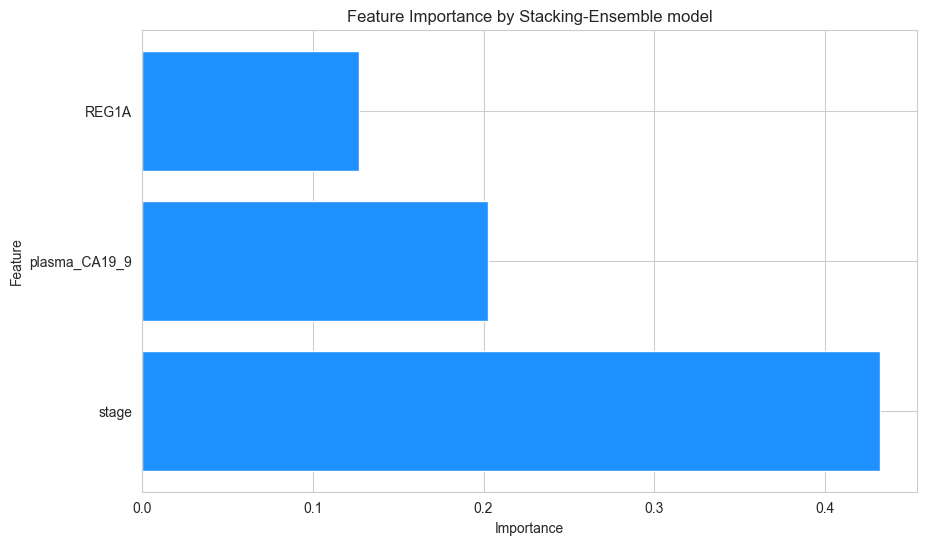

In [66]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="dodgerblue")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Stacking-Ensemble model')
plt.gca().invert_yaxis()

plt.show()

In [29]:
#PPRECISION-RECALL
import numpy as np
import matplotlib.pyplot as plt

# List of models
models = [
    'RF', 'MLP', 'KNN', 'DT', 'SVM', 'GNB', 'SGD', 'XGBoost', 'AdaBoost'
]

precision = [93.16, 87.45, 89.01, 93.94, 89.38, 89.31, 83.34, 94.57, 96.67]
recall = [93.14, 85.34, 88.05, 91.92, 85.94, 82.83, 82.13, 92.93, 95.96]


np.random.seed(42)  

plt.figure(figsize=(10, 8))
for i, model in enumerate(models):
 
    recall_points = np.linspace(0, 1, 100)
   
    precision_points = np.clip(
        np.random.normal(loc=precision[i]/100, scale=0.05, size=100),
        0, 1
    )
   
    precision_points = np.sort(precision_points)[::-1]
    plt.plot(recall_points, precision_points, label=model)


plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves for 9 Models')
plt.legend()
plt.grid(True)
plt.show()




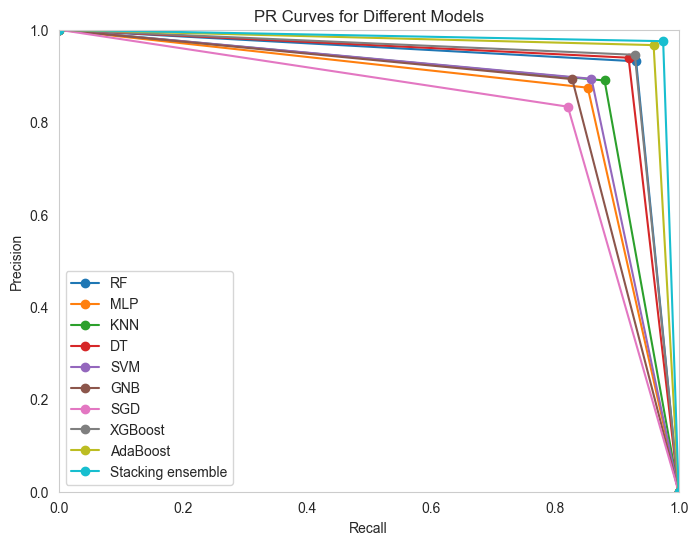

In [35]:
import matplotlib.pyplot as plt
import numpy as np

#  models
models = ['RF', 'MLP', 'KNN', 'DT', 'SVM', 'GNB', 'SGD', 'XGBoost', 'AdaBoost', 'Stacking ensemble']


precision = [93.16, 87.45, 89.01, 93.94, 89.38, 89.31, 83.34, 94.57, 96.67, 97.52]
recall = [93.14, 85.34, 88.05, 91.92, 85.94, 82.83, 82.13, 92.93, 95.96, 97.5]


plt.figure(figsize=(8,6))
for p, r, model in zip(precision, recall, models):
  
    r_points = [0, r/100, 1]
    p_points = [1, p/100, 0]
    plt.plot(r_points, p_points, marker='o', label=model)


plt.xlim(0, 1)
plt.ylim(0, 1)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves for Different Models')
plt.legend(loc='lower left')
plt.grid()

plt.show()



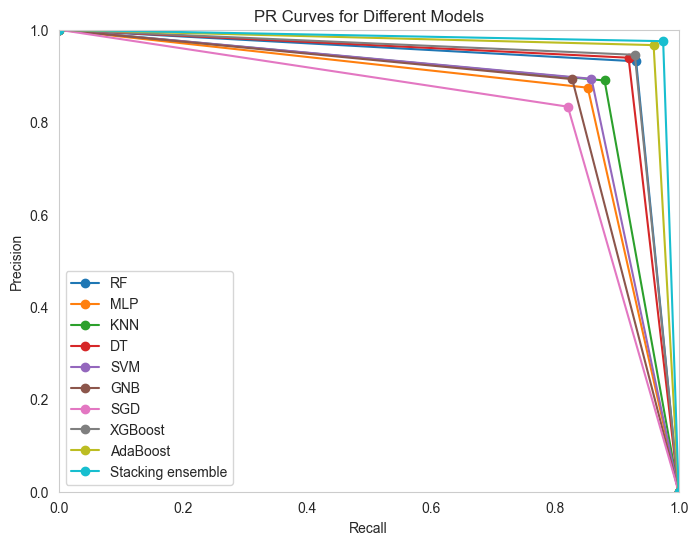

In [37]:
import matplotlib.pyplot as plt


#  models
models = ['RF', 'MLP', 'KNN', 'DT', 'SVM', 'GNB', 'SGD', 'XGBoost', 'AdaBoost', 'Stacking ensemble']


precision = [93.16, 87.45, 89.01, 93.94, 89.38, 89.31, 83.34, 94.57, 96.67, 97.52]
recall = [93.14, 85.34, 88.05, 91.92, 85.94, 82.83, 82.13, 92.93, 95.96, 97.5]


plt.figure(figsize=(8,6))
for p, r, model in zip(precision, recall, models):

    r_points = [0, r/100, 1]
    p_points = [1, p/100, 0]
    plt.plot(r_points, p_points, marker='o', label=model)


plt.xlim(0, 1)
plt.ylim(0, 1)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves for Different Models')
plt.legend(loc='lower left')
plt.grid()

plt.show()
